<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/CRVML/NN/BackgroundEstimatorML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [1]:
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
!pip install --upgrade tables

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_cry4')
from utils import Utils
util = Utils()
import math



     |████████████████████████████████| 4.3 MB 21.7 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
Mounted at /content/drive


In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

In [3]:
TMIN = -125
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 120
PMIN_PHY = 103.85
PMAX_PHY = 105.1
NNCUT = 0.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]
cut_lbox = " & ".join(cuts)


crv_time = "( crvinfo__dT < %d | crvinfo__dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_current = cut_extmom
#cut_current = cut_current+" & "+crv_time


#Load dataframe

In [4]:
cosmic = pd.read_hdf('drive/MyDrive/root_files_cry4/cr4dfml.hd5', mode='r', key='df')
noise = pd.read_hdf('drive/MyDrive/root_files_cry4/noisedfml.hd5', mode='r', key='noise')
cry3df = pd.read_hdf('drive/MyDrive/root_files_cry4/cr3dfml.hd5', mode='r')

In [5]:
neve_current = len(cosmic.query(cut_current))
neve_phymom = len(cosmic.query(cut_phymom))
mom_scale = neve_current/neve_phymom
nncut_str='& ((pred<%f & crvinfo__PEs>0) | (pred<0.5 & crvinfo__PEs<0))'%NNCUT
cut_current_nn = cut_current+nncut_str
print(mom_scale)

23.918483220115583


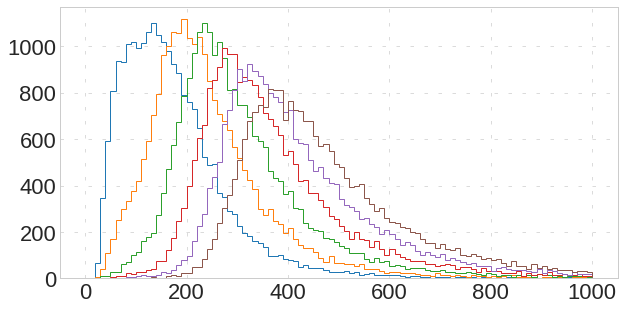

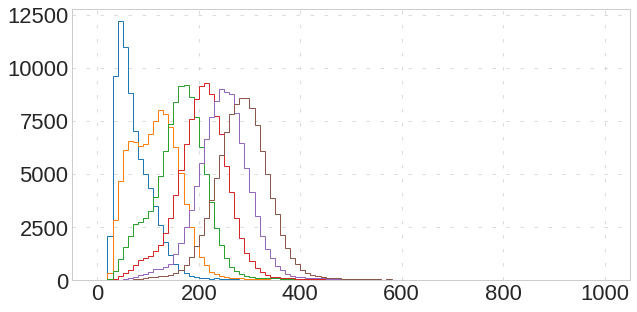

In [6]:
for l in range(7000,17001,2000):
  plt.hist(cosmic.query('is_high==1 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
for l in range(7000,17001,2000):
  plt.hist(cosmic.query('is_high==0 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');

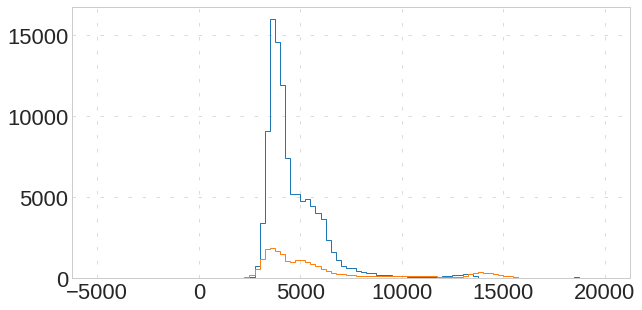

In [7]:
plt.hist(cosmic.query('is_high==0 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');
plt.hist(cosmic.query('is_high==1 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');

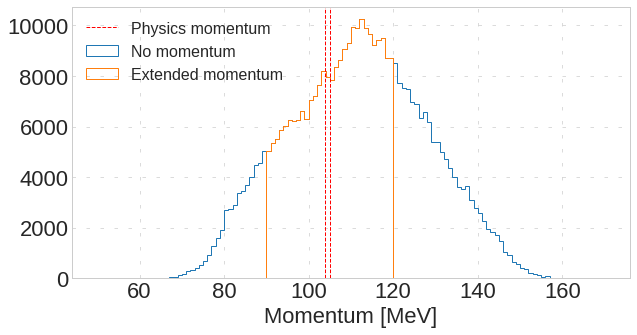

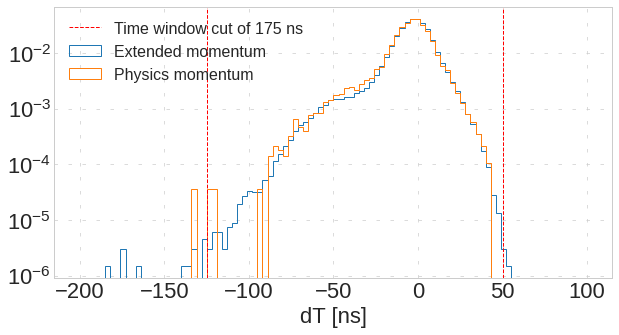

In [8]:
label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(cosmic.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(cosmic.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(cosmic.query(cut_extmom)['crvinfo__dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Extended momentum');
plt.hist(cosmic.query(cut_phymom)['crvinfo__dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut of 175 ns')
plt.yscale('log')
plt.xlabel('dT [ns]');
plt.legend(loc='upper left', prop={'size': 16})

In [9]:
util = Utils()
util.pritnLiveTimes()

LIVETIME_MU2E: 3.460000e+06
LIVETIME_HI: 5.490000e+06
LIVETIME_LO: 1.869000e+08


#Background estimation: production sources

In [10]:
def plot_background(cut_query, title, altitude_scale, log_scale=True, make_plot=True):

  lyield_scale=0.001726
  bg_ave = []
  pe_ave = []
  bg_err = []
  print(title)

  for ly in range(7000,17001,2000):
    bg = util.getNormBackground(cosmic, cut_query+" & lyield =="+str(ly), mom_scale)
    bg_ave.append(bg[0]*altitude_scale)
    pe_ave.append(ly*lyield_scale)
    bg_err.append(bg[1]*math.sqrt(altitude_scale))
    print("PE: %.1f, bg: %3.4f, err: %3.4f" % (ly*lyield_scale, bg[0]*altitude_scale, bg[1]))

  plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k');
  plt.title(title)
  if log_scale:
    plt.yscale('log')
  return (bg_ave, pe_ave, bg_err)

(-3000.0, 19000.0)

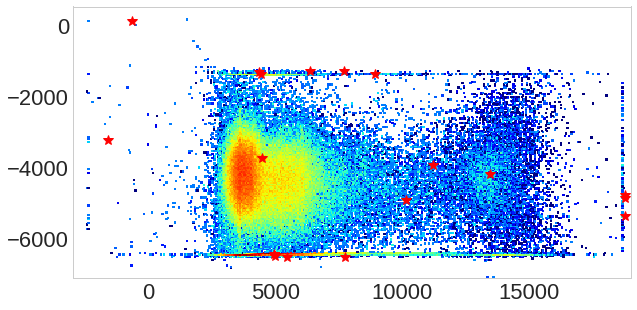

In [11]:
plotted = cosmic.query(cut_current_nn+'& lyield==17000')
plt.hist2d(cosmic.query('_z>-20000')['_z'], cosmic.query('_z>-20000')['_x'], bins=(400, 200), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
plt.plot(plotted['crvinfomc__z'], plotted['crvinfomc__x'], 'r*', label='non-vetoed', markersize=10);
plt.xlim(-3000, 19000)

In [12]:
utilcry3 = Utils()
utilcry3.LIVETIME_LO=3.83E+08 
utilcry3.LIVETIME_HI=1.28E+07 
utilcry3.pritnLiveTimes()

LIVETIME_MU2E: 3.460000e+06
LIVETIME_HI: 1.280000e+07
LIVETIME_LO: 3.830000e+08


Correlation for crvinfo__z: -0.003, 0.036
Correlation for crvinfo__PEs: -0.002, -0.013
Correlation for crvinfo__dT: -0.002, 0.160
Correlation for de_nhits: 0.375, 0.384


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Correlation for ue_nhits: nan, nan
Correlation for dequal_TrkPID: -0.071, -0.192
Correlation for dequal_TrkQual: 0.146, 0.272
Correlation for deent_td: 0.029, -0.005
Correlation for deent_z0: 0.006, 0.017
Correlation for deent_d0: -0.752, -0.745
Correlation for deent_om: -0.935, -0.961
Correlation for deent_d0_om: 0.549, 0.542


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

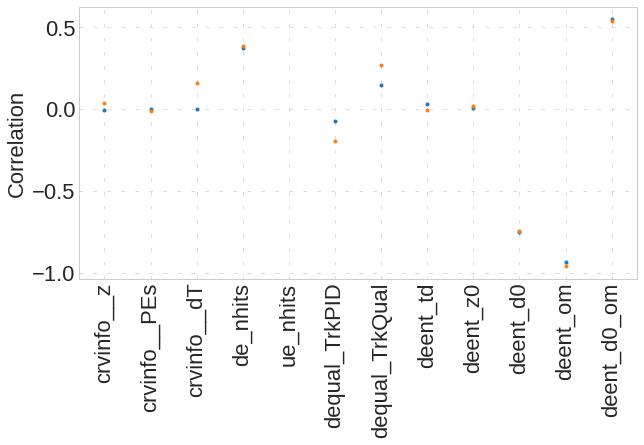

In [13]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

dTZPE_noMom_variables_list = {
                  'crvinfo__z': [-5000, 20000],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'deent_d0_om' : [300, 1200]
                  }

x = []
y_p = []
y_s = []

for var in dTZPE_noMom_variables_list.keys():
  corrp, _ = pearsonr(cosmic.query('deent_mom<200')['deent_mom'], cosmic.query('deent_mom<200')[var])
  corrs, _ = spearmanr(cosmic.query('deent_mom<200')['deent_mom'], cosmic.query('deent_mom<200')[var])
  print('Correlation for %s: %.3f, %.3f' % (var,corrp,corrs))
  x.append(var)
  y_p.append(corrp)
  y_s.append(corrs)

plt.plot(x, y_p, '.', label='pearson')
plt.plot(x, y_s, '.', label='spearman')
plt.ylabel('Correlation')
plt.xticks(rotation=90)

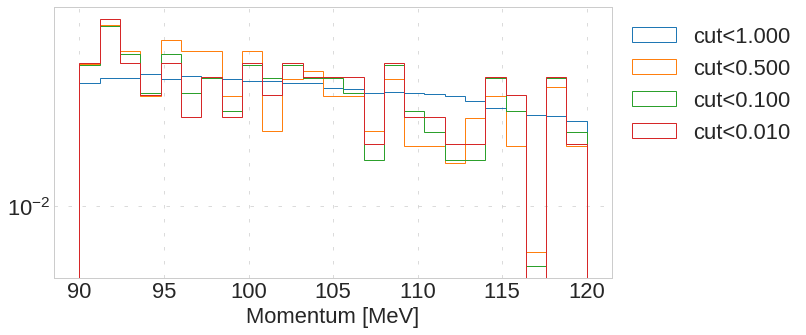

In [14]:
for cut in [1, 0.5, 0.1, 0.01]:
#  plt.hist(cry3df.query('pred<%f'%cut)['deent_mom'], range=(50, 150), histtype='step', bins=100, label=('cut<%.3f'%cut));
  plt.hist(cosmic.query('lyield==17000 & pred<%f'%cut)['deent_mom'], range=(PMIN_EXT, PMAX_EXT), histtype='step', bins=25, label=('cut<%.3f'%cut), density=True);
plt.yscale('log')
plt.xlabel('Momentum [MeV]')
#plt.xlim(90, 120)
#plt.legend()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)


(0.0, 0.3)

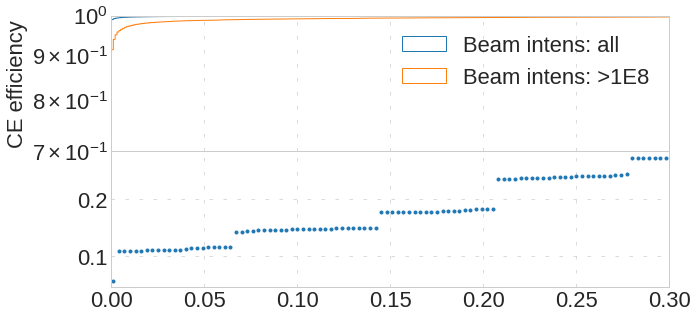

In [15]:
x = []
y_cry4 = []

import numpy as np

for cut in np.arange(0.001, 0.3, 0.003):

  bg = util.getNormBackground(cosmic.query("lyield ==17000"), cut_current+('& pred<%f'%cut), mom_scale)
#  print('CRY4 background: %.2f +/- %.2f, hi: %.2f, lo: %.2f' % (bg[0], bg[1], bg[2], bg[3]))
  y_cry4.append(bg[0])
  x.append(cut)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
#fig.subplots_adjust(0,0,1,1,0,0)
fig.subplots_adjust(hspace=0)

noise = noise.query(cut_extmom+'& is_cosmic==0')
ax1.hist(noise['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', cumulative=True, density=True, label='Beam intens: all');
ax1.hist(noise.query('evtinfo__nprotons>1E8')['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', cumulative=True, density=True, label='Beam intens: >1E8');
ax1.set_yscale('log')
ax1.set_ylim(0.7, 1.0)
ax1.set_ylabel('CE efficiency')
ax1.legend()

ax2.plot(x, y_cry4, '.')
#ax2.set_yscale('log')
plt.xlim(0, 0.3)
  

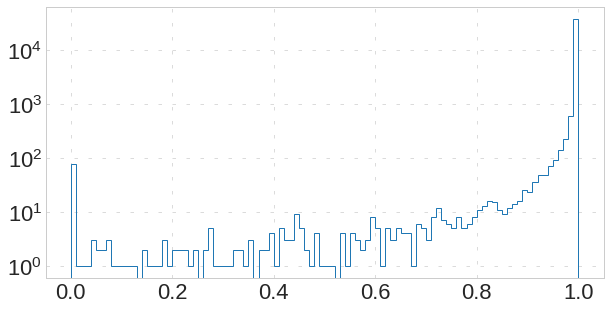

In [16]:
plt.hist(cosmic.query(cut_current+" & lyield ==17000")['pred'], histtype='step', bins=100);
plt.yscale('log')

Total Cosmic baclground
PE: 12.1, bg: 27.6842, err: 0.6953
PE: 15.5, bg: 7.3653, err: 0.3569
PE: 19.0, bg: 1.6462, err: 0.1617
PE: 22.4, bg: 0.6694, err: 0.1093
PE: 25.9, bg: 0.2717, err: 0.0651
PE: 29.3, bg: 0.1545, err: 0.0462


(0.001, 20)

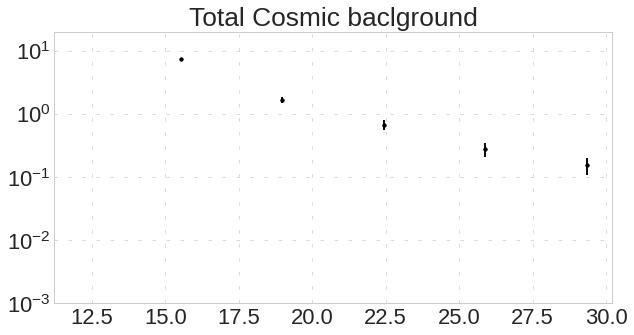

In [17]:
title='Total Cosmic baclground'
bg_ave, pe_ave, bg_err = plot_background(cut_current+('& pred<%f'%NNCUT), title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)
plt.yscale('log');
plt.ylim(0.001, 20)

Muons inside CRV
PE: 12.1, bg: 27.6086, err: 0.6952
PE: 15.5, bg: 7.3133, err: 0.3569
PE: 19.0, bg: 1.5958, err: 0.1616
PE: 22.4, bg: 0.6174, err: 0.1091
PE: 25.9, bg: 0.2196, err: 0.0648
PE: 29.3, bg: 0.1025, err: 0.0458
Non-muons
PE: 12.1, bg: 0.0548, err: 0.0059
PE: 15.5, bg: 0.0446, err: 0.0054
PE: 19.0, bg: 0.0446, err: 0.0054
PE: 22.4, bg: 0.0464, err: 0.0055
PE: 25.9, bg: 0.0455, err: 0.0054
PE: 29.3, bg: 0.0474, err: 0.0055
Muons outside CRV
PE: 12.1, bg: 0.0276, err: 0.0045
PE: 15.5, bg: 0.0130, err: 0.0031
PE: 19.0, bg: 0.0114, err: 0.0029
PE: 22.4, bg: 0.0114, err: 0.0029
PE: 25.9, bg: 0.0122, err: 0.0030
PE: 29.3, bg: 0.0106, err: 0.0028


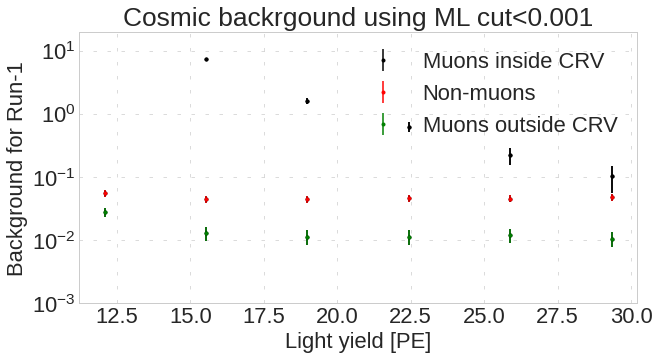

In [21]:
title='Muons inside CRV'
bg_ave, pe_ave, bg_err = plot_background(cut_current_nn+" & _crvSectorType > 0 & abs(demcgen_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

title = 'Non-muons'
bg_ave, pe_ave, bg_err = plot_background(cut_current_nn+" & abs(demcgen_pdg) != 13", title, 1.2, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.r', label=title)

title = 'Muons outside CRV'
bg_ave, pe_ave, bg_err = plot_background(cut_current_nn+" & _crvSectorType < 0 & abs(demcgen_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.g', label=title)
plt.legend()
plt.yscale('log');
plt.ylim(0.001, 20)
#plt.title('Cosmic backrgound using CRV dT cut');
plt.title('Cosmic backrgound using ML cut<0.001');
plt.xlabel('Light yield [PE]')
plt.ylabel('Background for Run-1');

#Background estimation: CRV regions

Background from muons inside the fiducial CRV region
PE: 12.1, bg: 27.6086, err: 0.6952
PE: 15.5, bg: 7.3133, err: 0.3569
PE: 19.0, bg: 1.5958, err: 0.1616
PE: 22.4, bg: 0.6174, err: 0.1091
PE: 25.9, bg: 0.2196, err: 0.0648
PE: 29.3, bg: 0.1025, err: 0.0458
Background from muons outside of fiducial CRV region
PE: 12.1, bg: 0.0276, err: 0.0045
PE: 15.5, bg: 0.0130, err: 0.0031
PE: 19.0, bg: 0.0114, err: 0.0029
PE: 22.4, bg: 0.0114, err: 0.0029
PE: 25.9, bg: 0.0122, err: 0.0030
PE: 29.3, bg: 0.0106, err: 0.0028
Background from non-muons
PE: 12.1, bg: 0.0548, err: 0.0059
PE: 15.5, bg: 0.0446, err: 0.0054
PE: 19.0, bg: 0.0446, err: 0.0054
PE: 22.4, bg: 0.0464, err: 0.0055
PE: 25.9, bg: 0.0455, err: 0.0054
PE: 29.3, bg: 0.0474, err: 0.0055


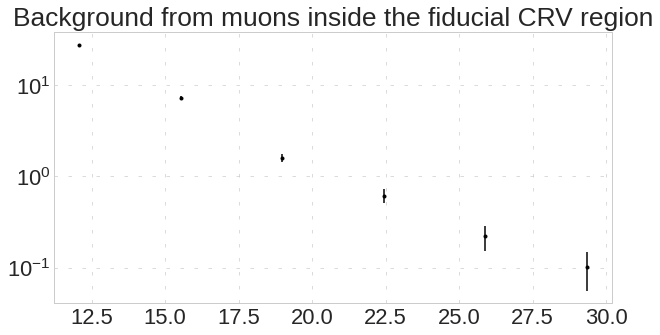

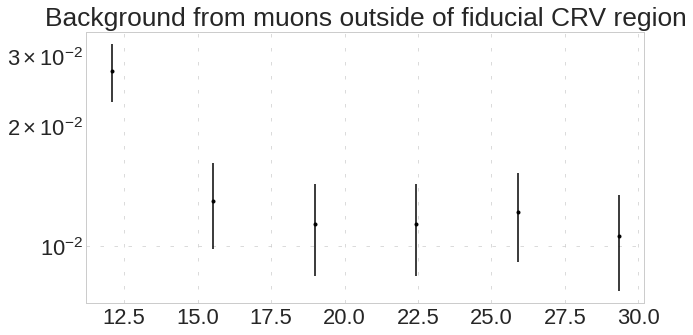

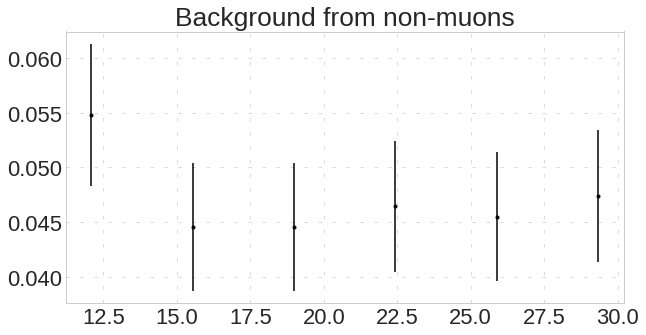

In [24]:
title='Background from muons inside the fiducial CRV region'
plot_background(cut_current_nn+" & _crvSectorType > 0 & abs(demcgen_pdg) == 13", title, 1.05)

plt.figure()
title = 'Background from muons outside of fiducial CRV region'
plot_background(cut_current_nn+" & _crvSectorType < 0 & abs(demcgen_pdg) == 13", title, 1.05)

plt.figure()
title = 'Background from non-muons'
plot_background(cut_current_nn+" & abs(demcgen_pdg) != 13", title, 1.2, False);

Background from sector R
PE: 12.1, bg: 50.9269, err: 1.1131
PE: 15.5, bg: 51.5372, err: 1.1203
PE: 19.0, bg: 51.3899, err: 1.1187
PE: 22.4, bg: 51.4965, err: 1.1197
PE: 25.9, bg: 50.8675, err: 1.1125
PE: 29.3, bg: 51.3492, err: 1.1178
Background from sector L
PE: 12.1, bg: 3.9554, err: 0.3097
PE: 15.5, bg: 3.8707, err: 0.3063
PE: 19.0, bg: 3.9261, err: 0.3086
PE: 22.4, bg: 3.8406, err: 0.3052
PE: 25.9, bg: 3.9546, err: 0.3097
PE: 29.3, bg: 3.8447, err: 0.3052
Background from sector T
PE: 12.1, bg: 155.8024, err: 1.8182
PE: 15.5, bg: 157.0963, err: 1.8275
PE: 19.0, bg: 156.4511, err: 1.8235
PE: 22.4, bg: 154.9515, err: 1.8141
PE: 25.9, bg: 156.4275, err: 1.8233
PE: 29.3, bg: 156.4207, err: 1.8222
Background from sector E
PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0277, err: 0.0263
PE: 19.0, bg: 0.0277, err: 0.0263
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0277, err: 0.0263
Background from sector U
PE: 12.1, bg: 0.0277, err: 0.0263
PE: 15.

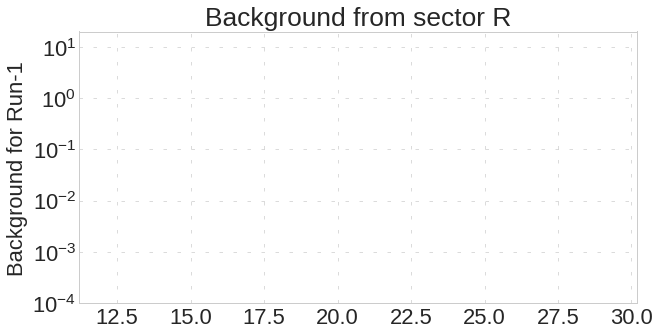

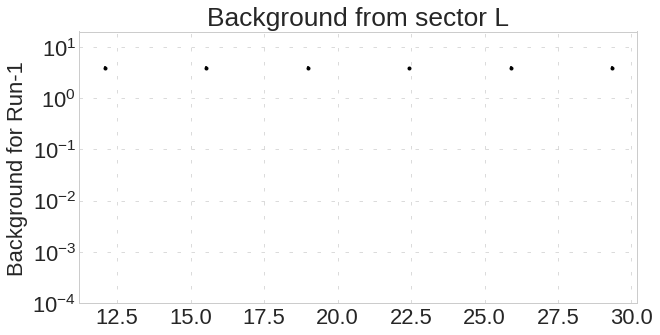

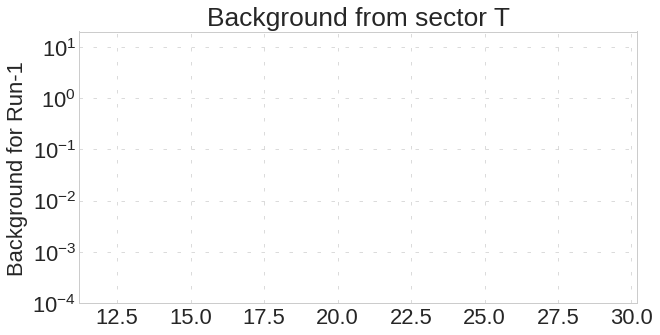

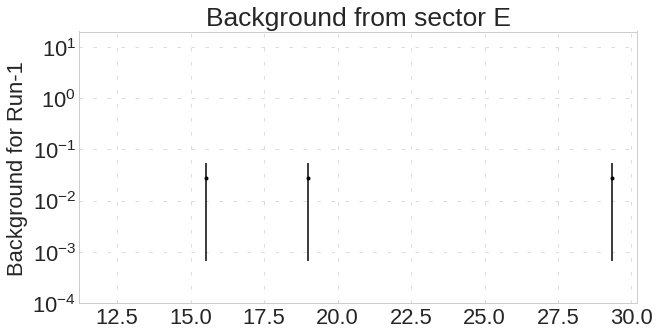

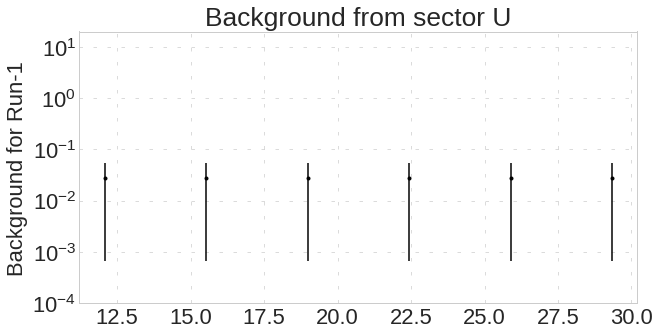

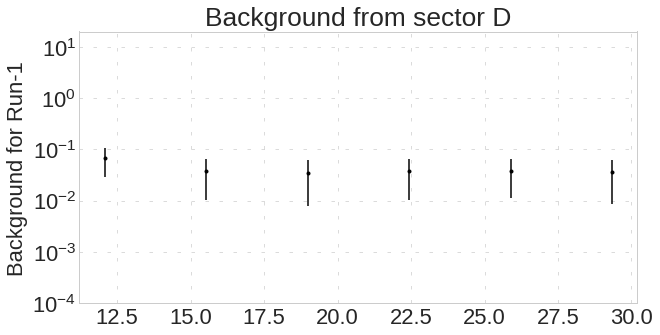

In [23]:
crvSectorLabel = ['R', 'L', 'T', 'E', 'U', 'D']
for crvSectorType in range(1,7):
  plt.figure()
  title='Background from sector %s' % crvSectorLabel[crvSectorType-1]
  cut_ = cut_current+(" & _crvSectorType ==%d  & abs(demcgen_pdg) == 13" % crvSectorType)
  plot_background(cut_, title, 1.05)
  plt.ylim(0.0001, 20)
  plt.ylabel('Background for Run-1')